<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background- padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Signal Processing and Classification
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:18px;font-family:Arial'><b>Introduction</b></p>

<p style = 'font-size:16px;font-family:Arial'>Navigation in oceans and deep waters are hugely dependent on sonar systems and signal processing. These systems serve a multitude of purposes, from detecting mines to guiding ship routes while considering marine life for sustainability.<br>
Despite their importance, sonar systems face considerable challenges in underwater environments, mainly due to the diverse array of noise sources present.These disturbances can significantly impede signal processing, potentially leading to erroneous target classification.</p> 

<p style = 'font-size:18px;font-family:Arial'><b>Business Value </b></p>
<li style = 'font-size:16px;font-family:Arial'>Signal processing to filter the noise signals present.</li>
<li style = 'font-size:16px;font-family:Arial'>Engineering time-domain features such as the Auto-Correlation Function (ACF) and Univariate Statistics for each audio frame. </li>
<li style = 'font-size:16px;font-family:Arial'>Extracting meaningful information using signal processing techniques like Continuous Wavelet Transform (CWT). </li>
<li style = 'font-size:16px;font-family:Arial'>Classification of the signals based of derieved features.</li></p>  
<p style = 'font-size:18px;font-family:Arial'><b>Why Vantage? </b></p>

<p style = 'font-size:16px;font-family:Arial'>Unbounded Array Framework (UAF) is the Teradata framework for building end-to-end time series forecasting pipelines and it also provides functions for digital signal processing and 4D spatial analytics. The series can reside in any Teradata supported or Teradata accessible table or in an analytic result table (ART). With Teradata Vantage, users can perform UAF functions at scale and analyze hundreds/thousands records at once. The UAF architecture provides a range of unique benefits including: </p>
<li style = 'font-size:16px;font-family:Arial'>Rapid data exploration, preparation, and testing functions that can analyze massive amounts of data across an unlimited number of signals in parallel; drastically reducing the development and testing times. </li>
<li style = 'font-size:16px;font-family:Arial'>The ability to deploy the preparation functions into automated pipelines that can run in near-real-time, eliminating the gaps between preparation, development, and deployment. 
</li>
<p></p>    

<p style = 'font-size:18px;font-family:Arial'><b>This Use Case</b></p>
<p style = 'font-size:16px;font-family:Arial'>This notebook will showcase the complete approach to classifying a dataset of sonar signals.  We wil extract and engineer the features and use those to train and score our models using the ClearScape Analytics platform. The dataset we are using is a sample of signals that will allow us to distinguish between right whale calls and other sounds. Label column is set to 1 when the signal is for right whale call and 0 otherwise.<br>The original dataset can be found <a href = 'https://www.kaggle.com/competitions/whale-detection-challenge/data'>here.</a></p>


<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>1. Connect to Vantage.</b></p>

In [ ]:
import numpy as np
import pandas as pd
import pywt
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from teradataml import *

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Modify the following to match the specific client environment settings
display.max_rows = 5

<p style = 'font-size:16px;font-family:Arial'>We will be prompted to provide the password. We will enter the password, press the Enter key, and then use the down arrow to go to the next cell.</p>

In [ ]:
%run -i ../startup.ipynb
eng = create_context(host = 'host.docker.internal', username='demo_user', password = password)
print(eng)

In [ ]:
%%capture
execute_sql('''SET query_band='DEMO=Signal_Processing_and_Classification_Python.ipynb;' UPDATE FOR SESSION; ''')

<p style = 'font-size:16px;font-family:Arial'>Begin running steps with Shift + Enter keys. </p>

<p style = 'font-size:18px;font-family:Arial'><b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial'>We have provided data for this demo on cloud storage. You can either run the demo using foreign tables to access the data without any storage on your environment or download the data to local storage, which may yield faster execution. Still, there could be considerations of available storage. Two statements are in the following cell, and one is commented out. You may switch which mode you choose by changing the comment string.</p>

In [ ]:
# %run -i ../run_procedure.py "call get_data('DEMO_Sonar_cloud');"        # Takes 30 seconds
%run -i ../run_procedure.py "call get_data('DEMO_Sonar_local');"        # Takes 4 minutes

<p style = 'font-size:16px;font-family:Arial'>
Optional step – We should execute the below step only if we want to see the status of databases/tables created and space used.

In [ ]:
%run -i ../run_procedure.py "call space_report();"        # Takes 10 seconds

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>2. Data Exploration</b></p>
<p style = 'font-size:16px;font-family:Arial'>Let us start by creating a "Virtual DataFrame" that points directly to the dataset in Vantage. We can check the shape and datatypes of all the columns of the dataframe.</p>


In [ ]:
tdf = DataFrame(in_schema("DEMO_Sonar" ,"Sonar_Data"))
tdf

In [ ]:
tdf.shape

<p style = 'font-size:16px;font-family:Arial'>The dataset contains 4million records</p>

In [ ]:
tdf_count = tdf.assign(drop_columns=True,
                       distinct_ID=tdf.ID.distinct().count())
tdf_count

<p style = 'font-size:16px;font-family:Arial'>The dataset contains 1000 unique ids</p>

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>2. Raw Audio Signal</b></p>

<p style = 'font-size:16px;font-family:Arial'>
A signal represents a sound waves.  A sound wave is a vibration that can transmit through different mediums: solids, gases, or liquids.  A wave can be described as having a wavelength, amplitude, speed and direction.  To capture these properties, sound can be captured at different sample rates.  The sound waves for this dataset were captures at 2kHz (2000 samples per second).<br>
<br>    
What we've gathered through this sampling process is a waveform for the signal. This waveform can be interpreted, modified, and analyzed using computer software, allowing us to extract valuable information and insights from the audio data. Working together, we can delve into the intricacies of the waveform to uncover its underlying characteristics and meaning. </p>


<p style = 'font-size:18px;font-family:Arial'><b>Visualization of Audio Signal</b></p>

<p style = 'font-size:16px;font-family:Arial'>The "td_plot" method in Teradata Vantage simplifies large-scale visualization by allowing users to create visualizations directly within the Vantage environment. It eliminates the need for data movement, enhancing efficiency and addressing challenges associated with handling extensive datasets. The generated charts can be in the JPG, PNG, or SVG formats.<br>
The following chart styles are available:
<ul style = 'font-size:16px;font-family:Arial'>
<li>Line</li>
<li>Scatter</li>
<li>Bar</li>
<li>Mesh</li>
<li>Seismic wiggle</li>
<li>Geometry</li>
</ul>
</p>

In [ ]:
tdf_sample =tdf[tdf.ID==1]
tdf_sample

In [ ]:
tdf_sample.shape

<p style = 'font-size:16px;font-family:Arial'>We have 4,000 records for one ID.</p> 

In [ ]:
figure = Figure(width=1200, height=600, heading='Sonar Audio Sample')

plot = tdf_sample.plot(
    x=tdf_sample.ROW_I,
    y=tdf_sample.AMPLITUDE,
    xlabel='Sample#',
    ylabel='Amplitude',
    color='carolina blue',
    figure=figure,
    legend='Sonar Signal',
    legend_style='upper right',
    grid_linestyle='--',
    grid_linewidth=0.5,
    )

plot.show()

<p style = 'font-size:16px;font-family:Arial'>The above plot shows the signal of ID =1.

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>3. Baseline Model</b></p>

<p style = 'font-size:16px;font-family:Arial'>In machine learning, a baseline model is a simple, often minimalistic model that serves as a starting point for comparison when developing more complex models. It's a fundamental concept in the machine learning workflow, and it provides a reference point to evaluate the performance of more sophisticated models.
<br>
The primary purpose of a baseline model are:<br>
    1. <b>Benchmarking:</b> It provides a basic benchmark to measure the effectiveness of more advanced models. This benchmark helps you determine if your complex models are worth the added complexity and computational resources.<br>
    2. <b>Understanding Data:</b> A baseline model can help you gain insights into the dataset you're working with. It highlights the simplest patterns and relationships in the data.<br>
    3. <b>Debugging:</b> Creating a baseline model early in the development process can help you identify data preprocessing or modeling issues. If your baseline model performs poorly, it's an indicator that there may be problems with your data or approach.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Feature Engineering</b></p>

<p style = 'font-size:16px;font-family:Arial'>Feature engineering is a critical step in the machine learning process. It involves creating, modifying, or selecting features from your dataset to improve the performance of your models. Well-crafted features can make a substantial difference in model accuracy and interpretability.
<br>
For our baseline model, we'll be engineering time-domain features for each audio frame using <b>ACF</b> and <b>Univariate Statistics</b>.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Univariate Statistics</b></p>

<p style = 'font-size:16px;font-family:Arial'>The <b>UnivariateStatistics()</b> function displays descriptive statistics for each specified numeric input table column.<br>
In our demo, we are using the following statistics for each ID:</p>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>Mean</li>
        <li>Standard Deviation</li>
        <li>Minimum</li>
        <li>Maximum</li>
        <li>Skewness</li>
        <li>Kurtosis</li>
    </ul>

In [ ]:
uni_obj = UnivariateStatistics(newdata=tdf, target_columns='AMPLITUDE',
                               partition_columns=['ID'],
                               stats=['MEAN',
                                      'SKEWNESS',
                                      'STANDARD DEVIATION',
                                      'KURTOSIS',
                                      'MINIMUM',
                                      'MAXIMUM',]
                              )
uni_obj.result

In [ ]:
uni_df = uni_obj.result.pivot(columns=uni_obj.result.StatName, aggfuncs=uni_obj.result.StatValue.max())
uni_df

<p style = 'font-size:16px;font-family:Arial'>From the above output, we can see that we have done the univariate analysis for each ID and then used pivot function to get the statistics values as attributes for each ID.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Auto Correlation</b></p>

<p style = 'font-size:16px;font-family:Arial'>The <b>ACF()</b> function calculates the autocorrelation or autocovariance of a time series. Autocorrelation and autocovariance show how the time series correlates or covaries with itself when delayed by a lag in time or space. When ACF is computed, a coefficient corresponding to a particular lag is affected by all the previous lags. For example, the coefficient for lag 4 includes effects of activity at lags 3, 2, and 1.<br>Here, we are using the lag of 15.</p>

In [ ]:
data_series_df = TDSeries(data=tdf,
                          id="ID",
                          row_index="ROW_I",
                          row_index_style="SEQUENCE",
                          payload_field="AMPLITUDE",
                          payload_content="REAL")
acf = ACF(data=data_series_df,
        max_lags=15)

In [ ]:
d2=acf.result
copy_to_sql(df = d2,table_name = "acf_data",if_exists='replace')
acf_data = DataFrame("acf_data")
acf_df = acf_data.pivot(columns=acf_data.ROW_I, aggfuncs=acf_data.OUT_AMPLITUDE.max())
acf_df

<p style = 'font-size:16px;font-family:Arial'>In the above steps we have calculated the ACF of 15lags for each ID and then pivoted the values to for the attributes.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Combining Auto-Correlation and Univariate Statistics</b></p>

<p style = 'font-size:16px;font-family:Arial'>Now, we'll be joining the ACF features with the univariate statistics and move towards creating a final Analytical Datase(ADS).</p>

In [ ]:
join_df=uni_df.join(other = acf_df, on = ["ID"], how = "inner",lprefix = "uni", rprefix = "acf")
join_df

<p style = 'font-size:16px;font-family:Arial'>We can cross check the columns in the joined dataframe and the acf and univariate dataframes.</p>

In [ ]:
print("\033[1mjoin_df shape:\033[0m",join_df.shape,"| \033[1muni_df shape:\033[0m",uni_df.shape,"| \033[1macf_df shape:\033[0m",acf_df.shape)

In [ ]:
base_df = join_df.assign(
    drop_columns=True,
    ID=join_df.uni_ID,
    Minimum=join_df.max_statvalue_minimum,
    Maximum=join_df.max_statvalue_maximum,
    Mean=join_df.max_statvalue_mean,
    StdDeviation=join_df.max_statvalue_standarddeviation,
    Skewness=join_df.max_statvalue_skewness,
    Kurtosis=join_df.max_statvalue_kurtosis,
    ACF_0=join_df.max_out_amplitude_0,
    ACF_1=join_df.max_out_amplitude_1,
    ACF_2=join_df.max_out_amplitude_2,
    ACF_3=join_df.max_out_amplitude_3,
    ACF_4=join_df.max_out_amplitude_4,
    ACF_5=join_df.max_out_amplitude_5,
    ACF_6=join_df.max_out_amplitude_6,
    ACF_7=join_df.max_out_amplitude_7,
    ACF_8=join_df.max_out_amplitude_8,
    ACF_9=join_df.max_out_amplitude_9,
    ACF_10=join_df.max_out_amplitude_10,
    ACF_11=join_df.max_out_amplitude_11,
    ACF_12=join_df.max_out_amplitude_12,
    ACF_13=join_df.max_out_amplitude_13,
    ACF_14=join_df.max_out_amplitude_14,
    ACF_15=join_df.max_out_amplitude_15,
    )
base_df

<p style = 'font-size:18px;font-family:Arial'><b>Analytical Data Set</b>

<p style = 'font-size:16px;font-family:Arial'>We have our final set features stored in dataframe <b>base_df</b>. Next, step is to join the Sonar_Label dataset to get the label(target) values and create a final ADS so that we can use it for training and validation of our models.</p>

In [ ]:
tdf_label = DataFrame(in_schema("DEMO_Sonar" ,"Sonar_Label"))
tdf_label

In [ ]:
tdf_label.shape

In [ ]:
ads_df=tdf_label.join(other = base_df, on = ["ID"], how = "inner",lprefix = "ads", rprefix = "base")
ads_df

<p style = 'font-size:18px;font-family:Arial'><b>Train-Test Split</b>

<p style = 'font-size:16px;font-family:Arial'>The <b>TrainTestSplit()</b> function divides the dataset into train and test subsets to be used for evaluating machine learning models and validation processes.<br>
75% is used for Training and 25% for validation.</p>

In [ ]:
TrainTestSplit_out = TrainTestSplit(
    data=ads_df,
    id_column='ads_ID',
    train_size=0.75,
    test_size=0.25,
    seed=42,
    stratify_column='LABEL',
    )

<p style = 'font-size:16px;font-family:Arial'>TD_IsTrainRow column has values 0 and 1. The test rows have a value of 0, and the train rows have a value of 1.
</p>

In [ ]:
train_df = TrainTestSplit_out.result[TrainTestSplit_out.result['TD_IsTrainRow'] == 1].drop(['TD_IsTrainRow'], axis = 1)
test_df  = TrainTestSplit_out.result[TrainTestSplit_out.result['TD_IsTrainRow'] == 0].drop(['TD_IsTrainRow'], axis = 1)
copy_to_sql(df = train_df, table_name = 'train_ads', if_exists = 'replace',primary_index = "ads_ID")
copy_to_sql(df = test_df, table_name = 'test_ads', if_exists = 'replace',primary_index = "ads_ID")

In [ ]:
train_ads=DataFrame("train_ads")
test_ads=DataFrame("test_ads")

In [ ]:
train_ads.shape

In [ ]:
test_ads.shape

<p style = 'font-size:16px;font-family:Arial'><b>Training Set</b>

In [ ]:
train_ads.select(['ads_ID','LABEL']).groupby(['LABEL']).agg('count')

<p style = 'font-size:16px;font-family:Arial'>The output shows the number of samples we are considering for each class to train the model.</p>

<p style = 'font-size:16px;font-family:Arial'><b>Testing Set</b>

In [ ]:
test_ads.select(['ads_ID','LABEL']).groupby(['LABEL']).agg('count')

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>4. Modelling</b></p>

<p style = 'font-size:18px;font-family:Arial'><b>Train a Decision Forest Model</b>

<p style = 'font-size:16px;font-family:Arial'>The <b>DecisionForest()</b> function is an ensemble algorithm used for classification and regression predictive modeling problems. It is an extension of bootstrap aggregation (bagging) of decision trees.</p>

In [ ]:
DecisionForest_out = DecisionForest(
    data=train_ads,
    input_columns=['3:24'],
    response_column='LABEL',
    max_depth=12,
    num_trees=36,
    min_node_size=1,
    mtry=15,
    tree_type='CLASSIFICATION',
    )

<p style = 'font-size:16px;font-family:Arial'>The DecisionForest function produces a model and a JSON representation of the decision tree. Below is explaination for some columns in the JSON tree. 
</p>
<html>
   <head>
      <style>
         table, th, td {
            border: 1px solid black;
            border-collapse:collapse;
         }
      </style>
   </head>
   <body>
      <table>
         <tr>
            <th>JSON Type</th>
            <th>Description</th>             
         </tr>
         <tr>
            <td>id_</td>
            <td>"Node identifier"</td>
         </tr>
         <tr>
            <td>nodeType_</td> 
            <td>The node type. Possible values: CLASSIFICATION_NODE,CLASSIFICATION_LEAF,REGRESSION_NODE,REGRESSION_LEAF.</td>
         </tr>
         <tr>
            <td>split_</td> 
            <td>The start of JSON item that describes a split in the node.</td>
         </tr> 
         <tr>
            <td>responseCounts_</td> 
            <td>[Classification trees] Number of observations in each class at node identified by id.</td>
         </tr>
         <tr>
            <td>size_</td> 
            <td>Total number of observations at node identified by id.</td>
         </tr> 
         <tr>
            <td>maxDepth_</td> 
            <td>Maximum possible depth of tree, starting from node identified by id. For root node, the
value is max_depth. For leaf nodes, the value is 0. For other nodes, the value is the
maximum possible depth of tree, starting from that node.</td>
         </tr>  
      </table>
   </body>
</html>


In [ ]:
DecisionForest_out.result.head(2)

<p style = 'font-size:16px;font-family:Arial'>The output shows JSON representation of the decision trees.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Predict labels using the Model</b></p>

<p style = 'font-size:16px;font-family:Arial'>We will use <b>TDDecisionForestPredict()</b> function to predict the class labels (classification) for our test dataset. </p>

In [ ]:
DF_Predict_out = TDDecisionForestPredict(
    newdata=test_ads,
    object=DecisionForest_out,
    id_column='ads_ID',
    output_prob=True,
    output_responses=['0', '1'],
    accumulate='LABEL',
    )

# Print the result DataFrame.
DF_Predict_out.result

<p style = 'font-size:16px;font-family:Arial'>The TDDecisionForestPredict() function creates probabilities for the prediction made depending on the class and the Id cloumns. The output of the predict function is passed to the Classification Evaluator to get the parameters of the functions. TDDecisionForestPredict() outputs the probability that each observation is in the predicted class. 

<p style = 'font-size:18px;font-family:Arial'><b>Evaluate the Model</b></p>

<p style = 'font-size:16px;font-family:Arial'> ClassificationEvaluator() function evaluates and emits various metrics of classification model based on its predictions on the data. Apart from accuracy, the secondary output data returns micro, macro, and weighted-averaged metrics of precision, recall, and F1-score values.<br>
This is a powerful function, and doesn't move data outside Vantage.

In [ ]:
# Evaluate classification.
ClassificationEvaluator_obj = ClassificationEvaluator(
                            data=DF_Predict_out.result,
                            observation_column='LABEL',
                            prediction_column='prediction',
                            labels=['0', '1']
                            )

# Print the result
ClassificationEvaluator_obj.output_data

<p style = 'font-size:18px;font-family:Arial'><b>Visualize the results</b></p>
<p style = 'font-size:16px;font-family:Arial'>In classification problems, a confusion matrix is used to visualize the performance of a classifier. The confusion matrix contains predicted labels represented across the row-axis and actual labels represented across the column-axis. Each cell in the confusion matrix corresponds to the count of occurrences of labels in the test data.<br><br>Clearscape Analytics can easily integrate with 3rd party visualization tools like Tableau, PowerBI, or many Python modules available such as plotly, seaborn, etc. We can perform all the calculations and pre-processing on Vantage, passing only the necessary information to visualization tools. This approach not only makes the calculations faster but also reduces the time due to less data movement between tools.</p>

In [ ]:
# Compute confusion matrix
cm = ClassificationEvaluator_obj.result.get(['CLASS_1', 'CLASS_2']).get_values().T

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Call', 'Call'])
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax, cmap = 'Blues', colorbar = True)

# Add labels and annotations
plt.title('DF ADS Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks = [0, 1], labels = ['No Call', 'Call'])
plt.yticks(ticks = [0, 1], labels = ['No Call', 'Call'])

# Add text to the plot to show the actual values of the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]}', ha = 'center', va = 'center', color = 'white' if cm[i, j] > cm.max()/1.4 else 'black')

# Remove grid lines
ax.grid(False)

# Show the plot
plt.show()

print(f'''
This means that out of all the actual non-call cases ({cm[0][0] + cm[0][1]}),
{round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}% were correctly classified as no call, while
{round(cm[0][1]/(cm[0][0] + cm[0][1])*100, 2)}% were incorrectly classified as call.
Similarly, out of all the actual call cases ({cm[1][0] + cm[1][1]}),
{round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}% were correctly classified as call, while
{round(cm[1][0]/(cm[1][0] + cm[1][1])*100, 2)}% were incorrectly classified as no call.
''')

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>5. Continuous Wavelet Transform</b></p>

<p style = 'font-size:16px;font-family:Arial'>The Continuous Wavelet Transform (CWT) is a powerful mathematical technique used in signal processing and image analysis. It is particularly useful for analyzing signals that vary in frequency over time. CWT provides a time-frequency representation of a signal, allowing us to capture and analyze signal components at different scales and locations.
<br>
The CWT is based on the concept of a wavelet, which is a small wave-like function that is used to analyze signals. The CWT of a signal is computed by sliding a wavelet function over the signal at different scales and positions, measuring the similarity between the wavelet and the signal at each position and scale.<br>
Here are some key concepts related to the CWT:<br>
<ol style = 'font-size:16px;font-family:Arial'>    
    <li> <b>Wavelet Function:</b> The choice of the wavelet function is crucial in CWT. It determines the shape of the wavelet and its frequency characteristics. Common wavelets include the Morlet, Mexican Hat, and Haar wavelets.</li>
<li> <b>Scale:</b> The CWT decomposes the signal into different scales, allowing you to capture both high-frequency and low-frequency components. Smaller scales capture high-frequency details, while larger scales capture low-frequency trends.</li>
<li> <b>Time-Frequency Representation:</b> CWT provides a time-frequency representation of the signal, showing how the signal's frequency content evolves over time.</li>
<li> <b>Scalogram:</b> The CWT result is often visualized as a scalogram, which is a 2D representation with time on one axis and scale (or frequency) on the other. The intensity of the scalogram represents the strength of the wavelet transform at different scales and times.</li>
    </ol>
<p style = 'font-size:16px;font-family:Arial'>    
CWT can help identify relevent patterns and structures in data. In this use case, we are using CWT to extract discriminative features for Machine Learning modelling.
</p>


<p style = 'font-size:18px;font-family:Arial'><b>CWT Example</b></p>

<p style = 'font-size:16px;font-family:Arial'>We created a signal in time domain using two cosine waves with different frequencies. Sampling rate is set to 1khz. First wave has a frequency of 100hz and it lasts between 0 and 250 ms. And other wave has a frequency of 50hz and it lasts between 500 and 750 ms. This signal is shown in the left figure below. CWT of this signal is visualized in a 2D spectogram as shown in the right. The x-axis shows the time axis with length equal to number of samples in the signal (1000 in this case). The y-axis shows the frequency in Hz. The colormap shows the output of CWT. The red regions are where the square of CWT coefficients is highest showing the presence of that frequency component at that time. For instance, in the figure we can see that within the timespan of 0-250 ms, we are getting a frequency of 100hz and within the timespan of 500-750 ms, we are getting a frequency of 50hz.</p>

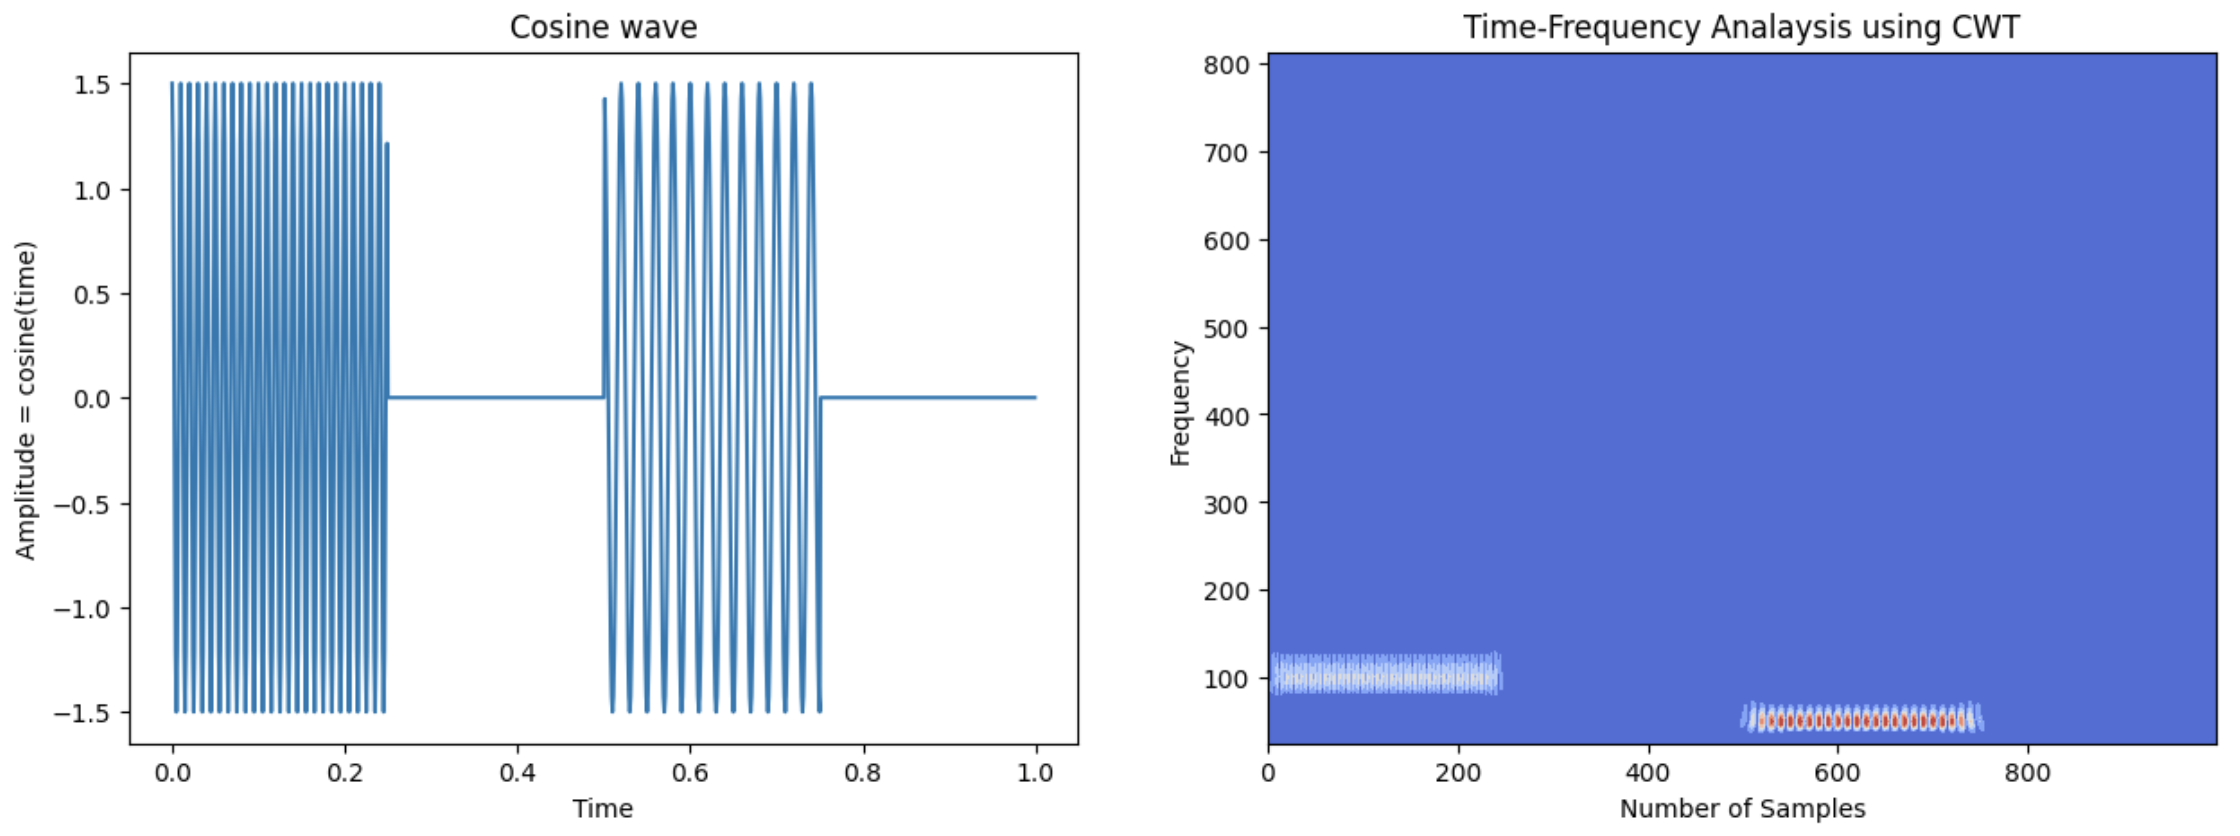

<p style = 'font-size:18px;font-family:Arial'><b>In-DB CWT Implementation and Feature Engineering</b></p>

<p style = 'font-size:16px;font-family:Arial'>
The Continuous Wavelet Transform is given as:
$$C_{a,b} = \frac{1}{\sqrt{a}}\sum_{k} s(k)\left( \int_{-\infty}^{k+1} \overline{\psi(\frac{t-b}{a})}dt - (\int_{-\infty}^{k} \overline{\psi(\frac{t-b}{a})}dt\right)$$
where a is the scale and b is the translation factor. The explanation of the formula can be found <a href = 'https://dsp.stackexchange.com/questions/70575/pywavelets-cwt-implementation'>here.</a> 
<p style = 'font-size:16px;font-family:Arial'>
As evident from the formula above, calculating CWT in Vantage can be divided into five major steps mentioned below:
<ul style = 'font-size:16px;font-family:Arial'>
<li> Wavelet Generation</li>
<li>Integration of Wavelet function</li>
<li>Dilation of wavelet for each scale</li>
<li>Convolution with signal data</li>
<li>Repeating the convolution per scale</li>
</ul>
</p> 


<p style = 'font-size:18px;font-family:Arial'><b>Wavelet Generation</b></p>

<p style = 'font-size:16px;font-family:Arial'> The first step of CWT calculation is to decide a wavelet. In our case, we are using a Morlet wavelet with the formula as shown: </p>
$$\psi (t) = exp^{(-t^2/2)}cos{(5t)}$$

<p style = 'font-size:16px;font-family:Arial'> where t is the time.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Timestamps</b></p>

<p style = 'font-size:16px;font-family:Arial'>We are generating a dataframe representing timestamps within the range [-8,8] with 1024 steps in between and storing it to Vantage using <b>copy_to_sql()</b> function</p>

<p style = 'font-size:18px;font-family:Arial'><b>Using GenseriesFormula() Function for Wavelet Generation</b></p>
<p style = 'font-size:16px;font-family:Arial'>The <b>GenseriesFormula()</b> allows us to define and apply a formula to generate a time series.
Here, we are implementing the equation of Morlet Wavelet shown above with time (t) stored in timestamps table.</p>

In [ ]:
DF = pd.DataFrame(np.linspace(-8, 8, num=1024),columns = ["MAGNITUDE"])
DF["ROW_I"] = np.arange(DF.shape[0])
DF["ID"] = 1
copy_to_sql(df = DF,table_name = "timestamps",if_exists='replace',primary_index = "ID")

In [ ]:
time_tdf= DataFrame("timestamps")
time_tdf

In [ ]:
gen_series = TDSeries(
    data=time_tdf,
    id='ID',
    row_index='ROW_I',
    row_index_style='SEQUENCE',
    payload_field='MAGNITUDE',
    payload_content='REAL',
    )

# Execute GenseriesFormula for TDGenSeries.
mor_uaf = GenseriesFormula(data=gen_series,
                           formula='Y = exp(-((X1*X1)/2))*cos(5*X1)',
                           output_fmt_index_style='NUMERICAL_SEQUENCE')
mor_uaf.result

<p style = 'font-size:18px;font-family:Arial'><b>Visualization of Wavelet</b></p>

<p style = 'font-size:16px;font-family:Arial'> We will use Vantage's plot() function to visualize the Morlet Wavelet which we just created.</p>

In [ ]:
figure = Figure(width=1200, height=600, heading="Morlet Wavelet")

plot = mor_uaf.result.plot(
    x=mor_uaf.result.ROW_I,
    y=mor_uaf.result.MAGNITUDE,
    xlabel='Sample#',
    ylabel='MAGNITUDE',
    color='carolina blue',
    figure=figure,
    legend='Morlet Signal',
    legend_style='upper right',
    grid_linestyle='--',
    grid_linewidth=0.5
)

plot.show()

<p style = 'font-size:18px;font-family:Arial'><b>Integration of Wavelet function</b></p>

<p style = 'font-size:16px;font-family:Arial'>The next step is to integrate the conjugate of created wavelet w.r.t time. We won't have to implement actual integration because the wavelet is discrete in time and zero outside of [-8,8]. We can replace integration with simple cumulative sum logic. And Cumulative Sum can be used to approximate the integral as long as the step size is very small. Here, we are integrating the wavelet for convolution with the Signal.</p>

In [ ]:
x = time_tdf.get_values()
t=x[:, 0]
step=t[1]-t[0]
df = mor_uaf.result.sort('ROW_I')
df=df.assign(temp=df.MAGNITUDE*step)
df=df.assign(int_psi=df.temp.csum(sort_columns=[df.ROW_I]))
df=df.drop(columns=['temp'])
df

<p style = 'font-size:16px;font-family:Arial'>The output shows the Mangitude as well as integral. We will save this in table as Morlet_Wavelet.

In [ ]:
copy_to_sql(df = df,table_name = "Morlet_Wavelet",if_exists='replace')

<p style = 'font-size:18px;font-family:Arial'><b>Wavelet Scaling and Index Calculation</b></p>

<p style = 'font-size:16px;font-family:Arial'>
As discussed earlier, we need to decide the scales on which we have to calculate CWT. Scaling refers to the process of dilating a wavelet. For instance, a scale of 2 means that the original wavelet is dilated from [-8,8] to [-16,16].</p>

<p style = 'font-size:18px;font-family:Arial'><b>How to choose Wavelet Scales?</b></p>

<p style = 'font-size:16px;font-family:Arial'>
The decision of the number and range of scales is important for feature engineering. Scales are related to frequencies and they are inversely proportional to frequency. A higher scale means lower frequency. If we are exactly aware of what frequencies to expect in our data, we can set the scales accordingly. For instance, if we are a domain expert detecting human voice in audio data, we would know the frequencies we are looking for. In our case, we were not aware of exact frequency spectrum of input data so, we simply visualized the 2D spectrogram of wavelet transform of a subset of frames and chose the region where there was at least some spike in the output. Then we adjusted the scales according to model training results.    
</p>

<p style = 'font-size:18px;font-family:Arial'><b>Which Scales did we use?</b></p>

<p style = 'font-size:16px;font-family:Arial'> We started with scales of 1 to 32. We divided the scale range logarithmically with 5 values 
between each power of two (also known as octave). This means that there were five values between 1 and 2 included, 5 values between 2 and 4, 4 and 8 and so on. Thus, in total there are 26 scales. More about the theory of CWT scales can be read <a href = 'https://www.mathworks.com/help/wavelet/gs/continuous-and-discrete-wavelet-transforms.html'>here</a>. Also, you can see the Frequency below that will be targeted when we set a specific scale using the sampling rate of 2000.</p>

In [ ]:
v = 5
octaves = 5
scales = [(2**(j/v)) for j in range(0,(v*octaves) + 1)]
Scale_to_freq = pd.concat([pd.DataFrame(scales,columns = ["Scales"]),pd.DataFrame(scales,columns = ["Period"])/2000,pd.DataFrame(pywt.scale2frequency('morl', scales) / (1/2000),columns = ["Pseudo-Frequency"])],axis = 1)
Scale_to_freq

<p style = 'font-size:16px;font-family:Arial'>However, we also need to be aware of the issue of aliasing. Simply put, aliasing occurs when the highest frequency in the sampled signal is more than half the sampling frequency (violating the Nyquist criterion). We have the sampling frequency of 2khz, so our highest frequency in signal should not be more than 1kHz. Hence, we should eliminate all the scales in our list that correspond to frequency higher than 1kHz. We use an inbuilt scale to frequency converter from pywavelets for this purpose. The scales corresponding to 1-2kHz are from 1 to 2, so we eliminate these values. More about aliasing can be read <a href = 'https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#converting-frequency-to-scale-for-cwt'>here</a>.
After all this, we are finally left with 21 scales from 2 to 32.
</p>

<p style = 'font-size:18px;font-family:Arial'><b>How do we scale the wavelet?</b></p>

<p style = 'font-size:16px;font-family:Arial'>
Once we have decided what scales to use, the next step is to implement this scaling on the original wavelet. To do this, we use a subsampling approach where we increase the number of samples or indexes taken from the wavelet as the scale value increases. We have 1024 values of the original wavelet, but the number of values used for each scale will be different and there is a specific formula to calculate that. Basically, we double the number of samples as we double our scale. The details of this can be found <a href = 'https://dsp.stackexchange.com/questions/70575/pywavelets-cwt-implementation'>here</a>. The dilation can be explained with help of this figure.</p>

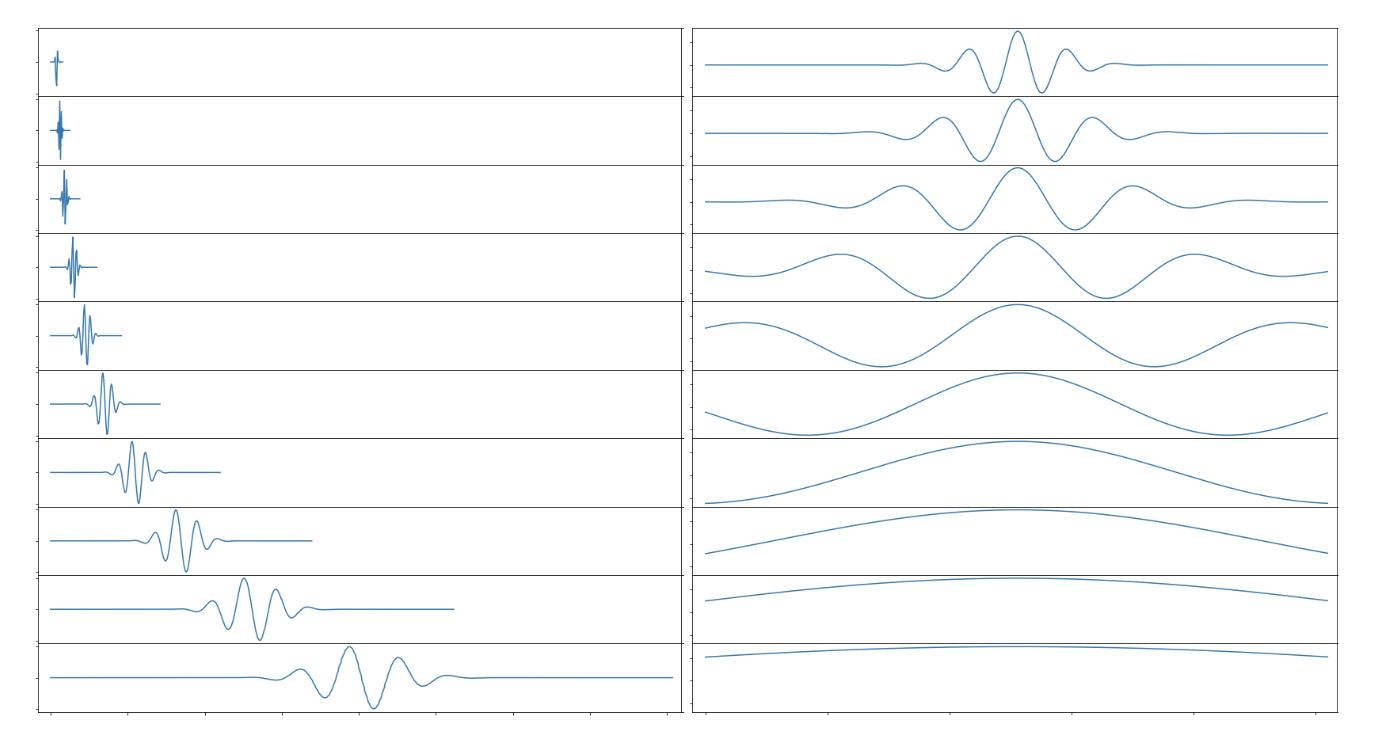

<p style = 'font-size:16px;font-family:Arial'>
On the left part of the figure, we can see our dilation logic in action. As the scale increases, the length of the wavelet increases but the shape remains the same. This is exactly what we want, the wavelet should increase in length but the shape of wavelet should be the same. On the right hand side, we see another dilation logic. The length of wavelet is kept fixed i.e. 1024 and the number of indexes are replicated as we increase the scale. This distorts the wavelet as the scales increases and hence, it isn't correct. We go ahead with the approach on the left.
</p>

<p style = 'font-size:18px;font-family:Arial'><b>Dilation of Wavelet for each scale</b></p>

<p style = 'font-size:16px;font-family:Arial'>Next step is to dilate the wavelet for each scale. The idea is to resample the wavelet at increasing resolution to change its scale. For example, we are using 33 samples to represent wavelet of scale 2. Similarly, we are increasing the scale to 4 by using 65 samples and so on. For this, we start with creating a Scales table that will have the corresponding indexes (Normal and Flipped) of each scale.</p>

In [ ]:
v = 5
octaves = 5
scales = [(2**(j/v)) for j in range(v,(v*octaves) + 1)]
step = t[1] - t[0]
DF = pd.DataFrame()
for scale in scales:
    row_i = np.arange(scale * (t[-1] - t[0]) + 1) / (scale * step)
    row_i = row_i.astype(int)
    if row_i[-1] >= t.size:
        row_i = np.extract(row_i < t.size, row_i)
    df = pd.DataFrame(row_i,columns = ["row_i"])
    df["row_j"] = row_i[::-1]
    df["scale"] = scale
    DF = pd.concat([DF,df],axis = 0)
DF

<p style = 'font-size:16px;font-family:Arial'>
We are storing this table in vantage.</p>

In [ ]:
copy_to_sql(df = DF,table_name = "W_Scale",if_exists='replace')

<p style = 'font-size:18px;font-family:Arial'><b>Intermediate Views for each Scale</b></p>

<p style = 'font-size:16px;font-family:Arial'>
We are creating separate views containing the Magnitude and Integral of our Wavelet for each Scale. These Views will also have the corresponding indexes (Normal and Flipped) of that particular scale.</p>

In [ ]:
for i, scale in enumerate(scales):
    execute_sql(f'''Replace View wavelet_{i} As (
                select t1.*,t2.row_j,t2.scale from Morlet_Wavelet t1
               inner join (select row_i,row_j,scale from W_Scale) t2
               on t1.row_i = t2.row_i
               where scale = {scale});''')

In [ ]:
tdf_scale_0 = DataFrame("wavelet_0")
tdf_scale_0

<p style = 'font-size:16px;font-family:Arial'>The output shows the View for Scale <b>2</b>.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Visualization of dilated Wavelets</b></p>

<p style = 'font-size:16px;font-family:Arial'>We use plot() to visualize the Morlet Wavelet dilated across different scales.</p>

In [ ]:
fig, axes = subplots(nrows=2, ncols=2)
fig.height,fig.width = 800,1024
fig.heading = "Dilation of Morlet Wavelet"
 
wavelets = ['wavelet_0', 'wavelet_5', 'wavelet_10', 'wavelet_15']
titles = ["Morlet Wavelet with Scale 2", "Morlet Wavelet with Scale 4",
         "Morlet Wavelet with Scale 8", "Morlet Wavelet with Scale 16"]
 
for i in range(len(wavelets)):
    plot = DataFrame(wavelets[i]).plot(
                x=DataFrame(wavelets[i]).ROW_I,
                y=DataFrame(wavelets[i]).MAGNITUDE,
                ax=axes[i],
                figure=fig,
                title=titles[i],
                xlabel='Sample#',
                ylabel='Amplitude',
                legend='Morlet Signal',
                color='carolina blue',
                grid_linestyle='--',
                grid_linewidth=0.5
    )
plot.show()


<p style = 'font-size:16px;font-family:Arial'>The output shows the resulting wavelet for increasing scale.</p> 

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>6. CWT Features Table</b></p>

<p style = 'font-size:16px;font-family:Arial'>
We are creating a table only containing ID which will hold the descriptive features of CWT at each scale.</p>

In [ ]:
c = DataFrame.from_query("select count(distinct(ID)) ID from demo_sonar.sonar_label;")
count=c.get_values()
col = [f"Minimum_{i} Maximum_{i} Skewness_{i} StandardDeviation_{i} Kurtosis_{i} Mean_{i}" for i in range(len(scales))]
columns = []
for i in range(len(col)):
    columns += col[i].split()
Features = pd.DataFrame([],columns = columns)
Features["ID"] = np.arange(1,count + 1)
Features.fillna(0.0,inplace = True)
copy_to_sql(df = Features, table_name = 'CWT_Features', if_exists = 'replace',primary_index = "ID")

<p style = 'font-size:18px;font-family:Arial'><b>CWT and Univariate Statistics Calculation</b></p>

<p style = 'font-size:16px;font-family:Arial'>
In this step, we are looping through the scales and performing following steps for each scale:
<ul style = 'font-size:16px;font-family:Arial'>
<li>Using <b>TD_CONVOLVE</b> to perform Convolution of signals with Integral of Wavelet of that scale.</li>
<li>Using <b>TD_DIFF</b> to take difference of the convolution result.</li>
<li>Using <b>TD_GENSERIES4FORMULA</b> for scaling.</li>
<li>Using <b>TD_UnivariateStatistics</b> to calculate statistics and storing the pivoted results.</li>
</ul>
</p> 

<p style = 'font-size:16px;font-family:Arial'>Since this is a 2CPU system, the below computation takes around 20min and so we have pre calculated it and stored in the table in database.</p>

<p style = 'font-size:16px;font-family:Arial'><i>**In case we still want to compute please set the If part of the below code to <b>True</b> instead of <b>False</b></i></p>

In [ ]:
%%time
if True:
    for i, scale in enumerate(scales):
        print("Scale:", scale)
        # Convolution
        execute_sql(f'''EXECUTE FUNCTION INTO VOLATILE ART(Convolution)
            TD_CONVOLVE(
               SERIES_SPEC(TABLE_NAME(demo_sonar.sonar_data),SERIES_ID(ID),ROW_AXIS(SEQUENCE(row_i)),
                  PAYLOAD( FIELDS(AMPLITUDE), CONTENT(REAL))),
               SERIES_SPEC(TABLE_NAME(wavelet_{i}),SERIES_ID(ID),ROW_AXIS(SEQUENCE(row_j)),
                  PAYLOAD( FIELDS(int_psi), CONTENT(REAL))) where ID = 1,
               FUNC_PARAMS(ALGORITHM("CONV_SUMMATION")),
               INPUT_FMT(INPUT_MODE(Many2One)));''')

        # Difference
        execute_sql('''EXECUTE FUNCTION INTO VOLATILE ART (DIFF)
          TD_DIFF (
            SERIES_SPEC (TABLE_NAME (Convolution), SERIES_ID (ID), ROW_AXIS(SEQUENCE(row_i)),
                  PAYLOAD (FIELDS (REAL_AMPLITUDE), CONTENT (REAL))),
              FUNC_PARAMS (
                LAG (1),
                DIFFERENCES (1),
                SEASONAL_MULTIPLIER (0)
              )
            );''')

        # Scaling
        execute_sql(f'''EXECUTE FUNCTION INTO VOLATILE ART(CWT)
            TD_GENSERIES4FORMULA(
              SERIES_SPEC(TABLE_NAME(DIFF), SERIES_ID(ID), ROW_AXIS(SEQUENCE(ROW_I)),
              PAYLOAD( FIELDS(OUT_REAL_AMPLITUDE), CONTENT(REAL))
              ),
              FUNC_PARAMS(
                  Formula('Y = (ABS(-sqrt({scale})*X1))**2')
              )
            );''')

        # Calculating statistical Features
        execute_sql('''REPLACE VIEW Statistical_Features AS
        SELECT * FROM TD_UnivariateStatistics (
        ON CWT AS InputTable
        USING
        TargetColumns ('MAGNITUDE')
        PartitionColumns ('ID')
        Stats( 
              'MEAN',
              'SKEWNESS',
              'STANDARD DEVIATION',
              'KURTOSIS',
              'MINIMUM',
              'MAXIMUM')
        ) As dt''')

        # Pivot and Update in final features table
        execute_sql(f'''
            UPDATE CWT_Features
            FROM (
                  SELECT ID, "Minimum", "Skewness", "StandardDeviation", "Maximum", "Kurtosis", "Mean"
                  FROM Statistical_Features
                  PIVOT
                  (
                    MAX(StatValue)
                    FOR StatName 
                        IN (
                            'MINIMUM' AS "Minimum", 
                            'SKEWNESS' AS "Skewness", 
                            'STANDARD DEVIATION' AS "StandardDeviation", 
                            'MAXIMUM' AS "Maximum", 
                            'KURTOSIS' AS "Kurtosis", 
                            'MEAN' AS "Mean"
                            )
                  ) PivotTable
            ) as t2
            SET Minimum_{i} = "Minimum", Maximum_{i} = "Maximum", Skewness_{i} = "Skewness", StandardDeviation_{i} = "StandardDeviation", Kurtosis_{i} = "Kurtosis", Mean_{i} = "Mean"
            where CWT_Features.ID = t2.ID
            ''')

        # Dropping Tables
        execute_sql('''drop table Convolution;''')
        execute_sql('''drop table DIFF;''')
        execute_sql('''drop table CWT;''')
    
    tdf_cwt = DataFrame("CWT_Features")
        
else:
    tdf_cwt = DataFrame(in_schema("DEMO_Sonar","CWT_Features_PreCal"))

<p style = 'font-size:18px;font-family:Arial'><b>Analytical Data Set</b></p>

<p style = 'font-size:16px;font-family:Arial'>We have our final set features stored in <b>tdf_cwt</b> dataframe. Next, step is to create a final ADS so that we can use it for training and validation of our models.</p>

In [ ]:
tdf_cwt

<p style = 'font-size:16px;font-family:Arial'>The output shows the analytical dataset containing the CWT features uniquely identified by ID column.</p>

In [ ]:
cwt_ads_df=tdf_cwt.join(other = tdf_label, on = ["ID"], how = "inner",lprefix = "cwt", rprefix = "ads")
cwt_ads_df

In [ ]:
cwt_ads_df.shape

<p style = 'font-size:18px;font-family:Arial'><b>Train-Test Split</b></p>

In [ ]:
TTS_cwt_out = TrainTestSplit(
    data=cwt_ads_df,
    id_column='ads_ID',
    train_size=0.75,
    test_size=0.25,
    seed=42,
    stratify_column='LABEL',
    )

In [ ]:
train_cwt_df = TTS_cwt_out.result[TTS_cwt_out.result['TD_IsTrainRow'] == 1].drop(['TD_IsTrainRow'], axis = 1)
test_cwt_df  = TTS_cwt_out.result[TTS_cwt_out.result['TD_IsTrainRow'] == 0].drop(['TD_IsTrainRow'], axis = 1)

In [ ]:
train_cwt_df.shape

In [ ]:
test_cwt_df.shape

In [ ]:
copy_to_sql(df = train_cwt_df, table_name = 'train_cwt', if_exists = 'replace',primary_index = "ads_ID")
copy_to_sql(df = test_cwt_df, table_name = 'test_cwt', if_exists = 'replace',primary_index = "ads_ID")

<p style = 'font-size:20px;font-family:Arial'><b>Modelling</b></p>

<p style = 'font-size:18px;font-family:Arial'><b>Train a Decision Forest Model</b></p>

In [ ]:
train_cwt=DataFrame("train_cwt")

In [ ]:
DF_cwt_out = DecisionForest(
    data=train_cwt,
    input_columns=['0:125'],
    response_column='LABEL',
    max_depth=12,
    num_trees=36,
    min_node_size=1,
    mtry=35,
    tree_type='CLASSIFICATION',
    )

In [ ]:
DF_cwt_out.result.head(2)

<p style = 'font-size:18px;font-family:Arial'><b>Predict labels using the Model</b></p>

In [ ]:
test_cwt=DataFrame("test_cwt")

In [ ]:
DF_cwt_predict_out = TDDecisionForestPredict(
    newdata=test_cwt,
    object=DF_cwt_out,
    id_column='ads_ID',
    output_prob=True,
    output_responses=['0', '1'],
    accumulate='LABEL',
    )

# Print the result DataFrame.
DF_cwt_predict_out.result

<p style = 'font-size:18px;font-family:Arial'><b>Evaluate the Model</b></p>

In [ ]:
# Evaluate classification.
CE_cwt_obj = ClassificationEvaluator(
        data=DF_cwt_predict_out.result,
        observation_column='LABEL',
        prediction_column='prediction',
        labels=['0', '1'])

# Print the result DataFrames.
CE_cwt_obj.output_data

<p style = 'font-size:18px;font-family:Arial'><b>Visualize the results</b></p>

In [ ]:
# Compute confusion matrix
cm = CE_cwt_obj.result.get(['CLASS_1', 'CLASS_2']).get_values().T

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Call', 'Call'])
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax, cmap = 'Blues', colorbar = True)

# Add labels and annotations
plt.title('DF ADS Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks = [0, 1], labels = ['No Call', 'Call'])
plt.yticks(ticks = [0, 1], labels = ['No Call', 'Call'])

# Add text to the plot to show the actual values of the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm[i, j]}', ha = 'center', va = 'center', color = 'white' if cm[i, j] > cm.max()/1.4 else 'black')

# Remove grid lines
ax.grid(False)

# Show the plot
plt.show()

print(f'''
This means that out of all the actual no call cases ({cm[0][0] + cm[0][1]}),
{round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}% were correctly classified as no call, while
{round(cm[0][1]/(cm[0][0] + cm[0][1])*100, 2)}% were incorrectly classified as call.
Similarly, out of all the actual call cases ({cm[1][0] + cm[1][1]}),
{round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}% were correctly classified as call, while
{round(cm[1][0]/(cm[1][0] + cm[1][1])*100, 2)}% were incorrectly classified as no call.
''')

<p style = 'font-size:18px;font-family:Arial'><b> Conclusion</b></p>
<p style = 'font-size:16px;font-family:Arial'>In this use case we have seen how we can use ClearScape Analytics for signal processing and how we can use it to create features which can be used in creation of classification models. Executing the functions in-db helps us to run them on large volumes of data.</p>

<hr style="height:2px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>7. Cleanup</b></p>
<p style = 'font-size:18px;font-family:Arial;color:##00233C'><b>Work Tables</b></p>
<p style = 'font-size:16px;font-family:Arial;color:##00233C'>We need to clean up our work tables to prevent errors next time.</p>

In [ ]:
views = [f'wavelet_{x}' for x in range(21)]
for view in views:
    try:
        db_drop_view(view_name=view)
    except:
        pass     
  

In [ ]:
tables = ['acf_data','train_ads','test_ads','timestamps','Morlet_Wavelet', 'W_Scale', 'CWT_Features','train_cwt','test_cwt']

# Loop through the list of tables and execute the drop table command for each table
for table in tables:
    try:
        db_drop_table(table_name=table)
    except:
        pass   
    

<p style = 'font-size:18px;font-family:Arial'><b>Databases and Tables</b></p>
<p style = 'font-size:16px;font-family:Arial'>We will use the following code to clean up tables and databases created for this demonstration.</p>  

In [ ]:
%run -i ../run_procedure.py "call remove_data('DEMO_Sonar');" 
#Takes 40 seconds

In [ ]:
remove_context()

<hr style="height:2px;border:none;">
<b style = 'font-size:20px;font-family:Arial'>Required Materials</b>
<p style = 'font-size:16px;font-family:Arial'>Let’s look at the elements we have available for reference for this notebook:</p>
<b style = 'font-size:18px;font-family:Arial'>Filters:</b> 
    <li style = 'font-size:16px;font-family:Arial'><b>Industry:</b> Defence</li>
<li style = 'font-size:16px;font-family:Arial'><b>Functionality:</b> Machine Learning</li> 
<li style = 'font-size:16px;font-family:Arial'><b>Use Case:</b> Signal Processing</li></p>

<footer style="padding-bottom:35px; background:#91A0AB; ">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            © 2024 Teradata. All rights reserved.
        </div>
    </div>
</footer>